In [1]:
import cProfile
import tensorflow as tf

import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import keras
from keras import callbacks as callbacks_module
from keras.models import Model
from keras.layers import Input, Dense, Layer
from keras.losses import Loss, mse
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import  plot_model

from keras.engine import data_adapter
import keras.backend

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# PINN: One-Dimensional Burger Equation

The Burgers' equation is a fundamental partial differential equation (PDE) that arises in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, and gas dynamics. The equation describes the evolution of a scalar field (like velocity, temperature, or density) that experiences both nonlinear convection and diffusion.

In its one-dimensional, unsteady, and inviscid form, the Burgers' equation is given by:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

Here, u(x, t) is the dependent variable (e.g., velocity), x is the spatial variable, t is the time variable, and ν is the kinematic viscosity coefficient. The first term on the left-hand side represents the time evolution, the second term represents the nonlinear convection, and the term on the right-hand side represents the diffusion or dissipation.

In the specific case considered in the provided code, the Burgers' equation is solved with the following conditions:

- **Domain**: The spatial domain is $x \in [1,-1]$, and the time domain is $t \in [0,1]$, the problem is being solved within this rectangular domain.
- **Initial Condition**: $u(0, x) = -\sin(\pi x)$ where $ x \in [-1, 1]$. This describes the initial state of the dependent variable $u(x, t)$ at time $t = 0$.
- **Boundary conditions**:u(t, -1) = u(t, 1) = 0, where $t \in [0,1]$. These conditions enforce that the dependent variable $u(x, t)$ is equal to zero at the boundaries $x = -1$ and $x = 1$ for all times t.



The goal is to train a physics-informed neural network (PINN) to approximate the solution $u(x, t)$ of the Burgers' equation under these conditions. The PINN is trained to minimize the residuals of the PDE, initial conditions, and boundary conditions by using randomly sampled points within the domain and points satisfying the initial and boundary conditions.

# Dense Neural Network (DNN): Model

In [3]:
class DNN(Model):
    def __init__(self,
                 layer_units: list = [32,16,32],
                 output_unit: int = 1,
                 activation_func: str = 'tanh',
                 initializer: str = "he_normal",
                 name="DNN"):
        """
        Initialize the DNN (Deep Neural Network) layer.

        Args:
            layer_units: A list of integers representing the number of units in each hidden layer .
            output_unit: An integer representing the number of units in the output layer .
            activation_func: A string representing the activation function used in the hidden layers .
            initializer: A string representing the kernel initializer used for the layers .
            name: A string representing the name of the layer.
        """
        super().__init__(name=name)

        self.units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.initializer = initializer

        # Hidden layers
        self.hidden_layer = []
        count = 0
        for unit in layer_units:
            self.hidden_layer.append(Dense(units=unit,
                                           kernel_initializer=self.initializer,
                                           activation=activation_func,
                                           name='Hidden_{}'.format(count)))
            count += 1

        # Output layer
        self.output_layer = Dense(units=output_unit,
                                  kernel_initializer=self.initializer,
                                  name="Output")

    def call(self, x):
        """
        Compute the forward pass of the DNN layer.

        Args:
            x: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            x: A tensor of shape (batch_size, output_unit), containing the output of the DNN layer.
        """

        for hidden in self.hidden_layer:
            x = hidden(x)

        x = self.output_layer(x)

        return x

# Automatic Diff: Layer

In [4]:
class AutomaticDiff(Layer):
    
    def __init__(self, dnn: DNN,
                         nu: float, 
                         name: str = 'AutomaticDiff'):
        """
        Initialize the AutomaticDiff layer.
        
        Args:
            dnn: A deep neural network (DNN) used for computing derivatives.
            nu: A float representing the viscosity coefficient in Burgers' equation.
            name: A string representing the name of this layer. Defaults to 'AutomaticDiff'.
        """

        self.dnn = dnn
        self.nu = nu
        super().__init__(name = name)

    def call(self, xt):
        """
        Compute the residual of Burgers' equation using the input tensor xt.
        
        This method computes the first and second derivatives of the DNN with respect to the input tensor, and then
        calculates the residual of Burgers' equation using these derivatives.

        Args:
            xt: A tensor representing the input data (spatial and temporal points).

        Returns:
            residual: A tensor representing the residual of Burgers' equation.
        """
        # Jacobian outputs shape: (batch, units, input_size)
        with tf.GradientTape() as gg:
            gg.watch(xt)
            with tf.GradientTape() as g:
                g.watch(xt)
                u = self.dnn(xt)  

            du_dxt =  g.batch_jacobian(u, xt)
            du_dx  = du_dxt[:,:,0]            
            du_dt = du_dxt[:,:,1] 

        d2u_dx2 = gg.batch_jacobian(du_dx, xt)[:,:,0] 


        residual = du_dt + u*du_dx - self.nu*d2u_dx2
        return residual

# Optimizer L-BFGS-B : Class

In [5]:
class L_BFGS_B:
    def __init__(self, 
                 model , 
                 x_train, 
                 y_train, 
                 loss_func,
                 factr: float = 1e7, 
                 m: int=50, 
                 maxls: int=50, 
                 maxiter: int=5000):
        """
        Initialize the L-BFGS-B optimizer with given model, data, loss function, and optimization parameters.

        Args:
            model: The model to be optimized.
            x_train: The input data (features) for training.
            y_train: The output data (labels) for training.
            loss_func: The loss function to be minimized during training.
            factr: The optimization parameter for L-BFGS-B (default: 1e7).
            m: The number of limited memory vectors for L-BFGS-B (default: 50).
            maxls: The maximum number of line search steps for L-BFGS-B (default: 50).
            maxiter: The maximum number of iterations for L-BFGS-B (default: 5000).
        """
   
        self.model = model
        self.loss_func = loss_func
        self.loss_tracker = None
        self.current_step = 0
        
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]

        # Store optimization parameters
        self.factr = factr
        self.m = m
        self.maxls = maxls 
        self.maxiter = maxiter
        self.metrics = ['loss']

        # Initialize the progress bar for displaying optimization progress
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':self.maxiter, 'steps':1, 'metrics':self.metrics})
   
    def set_weights(self, weights_1d):
        """
        Set the model's weights using a 1D array of weights.

        Args:
            weights_1d: A 1D numpy array representing the weights of the model.
        """

        #Set the model's weights using a 1D array of weights
        weights_shapes = [ w.shape for w in self.model.get_weights() ]
        n = [0] + [ np.prod(shape) for shape in weights_shapes ] 
        partition = np.cumsum(n) 
        weights = [ weights_1d[from_part:to_part].reshape(shape)
                        for from_part, to_part, shape 
                        in zip(partition[:-1], partition[1:], weights_shapes) ]
                        
        self.model.set_weights(weights)
    
    @tf.function
    def tf_evaluate(self, x, y):
        """
        Compute the model's loss and gradients for the given input (x) and output (y) tensors.

        Args:
            x: Input tensor.
            y: Output tensor.

        Returns:
            loss: The computed loss.
            grads: The computed gradients.
        """
        with tf.GradientTape() as tape:
            
            y_pred = self.model(x)
            loss = self.loss_func(y,  y_pred)
        grads = tape.gradient(loss, self.model.trainable_weights)
        return loss, grads
    
    def evaluate(self, weights_1d):
        """
        Evaluate the model's loss and gradients using the given 1D array of weights.

        Args:
            weights_1d: A 1D numpy array representing the weights of the model.

        Returns:
            loss: The computed loss.
            grads_concat: The computed gradients concatenated as a 1D numpy array.
        """
        # Evaluate the model's loss and gradients using the given 1D array of weights
        self.set_weights(weights_1d)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)

        # Convert the loss and gradients to numpy arrays for use with the L-BFGS-B optimizer
        loss = loss.numpy().astype('float64') 
        grads_concat = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')
        self.loss_tracker = loss
        return loss, grads_concat
    
    def callback(self,_):
        """
        Callback function to execute custom actions during optimization.

        Args:
            _: Unused argument for compatibility with the optimizer's callback signature.
        """

        # Update the progress bar at the specified interval
        update_interval = 1000
        if self.current_step % update_interval == 0:
            self.progbar.on_epoch_begin(self.current_step)
            loss = self.loss_tracker
            self.progbar.on_epoch_end(self.current_step, logs= {"loss":loss})
            
        self.current_step += 1

    def train(self):
        """
        Train the model using the L-BFGS-B optimization algorithm.
        """

        self.model(self.x_train)
        initial_weights = np.concatenate([ w.flatten() for w in self.model.get_weights() ])
        
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))

        self.progbar.on_train_begin()
        # Train the model using L-BFGS-B optimization
        fmin_l_bfgs_b(  func=self.evaluate, x0=initial_weights, factr=self.factr,
                        m=self.m, maxls=self.maxls, maxiter=self.maxiter, callback=self.callback )
        self.progbar.on_train_end()

# Physics Informed Neural Network (PINN): Model

In [6]:
class PINN(Model):
    def __init__(self,
                  dnn: DNN,
                  nu: float = 0.01/np.pi,
                  name: str =  'PINN'):
        super().__init__(name = name)

        """
        Initialize the Physics-Informed Neural Network (PINN) model.

        Args:
            dnn (DNN): A deep neural network object to use as the base model.
            nu (float, optional): The parameter nu used in the PDE equation. Defaults to 0.01/np.pi.
            name (str, optional): The name of the model. Defaults to 'PINN'.
        """
        
        self.dnn = dnn
        self.auto_diff = AutomaticDiff(self.dnn, nu)


    @property
    def metrics(self):
        """
        Return the list of loss trackers used in the model.
        """
        if not hasattr(self, 'loss_tracker'):
            self.loss_tracker = Mean(name="loss")
        return [self.loss_tracker] 

    def call(self, x_train): 
        """
        Compute the model outputs for the given inputs.

        Args:
            x_train (tuple): A tuple containing the input data for equation, initial conditions, and boundary conditions.

        Returns:
            tuple: The computed residuals, initial conditions, and boundary conditions.
        """     

        xt, xt_0, xt_bnd = x_train

        r = self.auto_diff(xt)
        u_0 = self.dnn(xt_0)
        u_bnd = self.dnn(xt_bnd)
        
        return (r, u_0, u_bnd)
    
    def train_step(self, data):
        """
        Train the model for one step using the given input and target data.

        Args:
            data (tuple): A tuple containing the input data and target data.

        Returns:
            dict: A dictionary containing the loss value for this training step.
        """
        return self._process_step(data)
    
    @tf.function
    def tf_evaluate_loss_grads(self, x, y):
        """
        Evaluate the loss and gradients for the given input and target data.

        Args:
            x (tf.Tensor): The input data.
            y (tf.Tensor): The target data.

        Returns:
            tuple: The loss and gradients for the given input and target data.
        """
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compute_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_weights)
        return loss, grads
    
    # Helper function to process one batch of data
    def _process_step(self, data):
        """
        Helper function to process one batch of data.

        Args:
            data (tuple): A tuple containing the input data and target data.

        Returns:
            dict: A dictionary containing the loss value for this training step.
        """
        x_train, y_train = data
        loss, grads = self.tf_evaluate_loss_grads(x_train, y_train)
        #if no other optimizer is choose and use_l_bfgs_b_optimizer = True
        # then self.optimizer = None and this is skipped
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the loss trackers
        self.loss_tracker.update_state(loss)
    
        return {"loss": self.loss_tracker.result()}
    
    def compute_loss(self, y_train, y_pred):
        """
        Compute the loss between the predicted and target values.

        Args:
            y_train (tf.Tensor): The target data.
            y_pred (tf.Tensor): The predicted data.

        Returns:
            tf.Tensor: The computed loss.
        """
        loss = tf.reduce_mean(mse(y_pred, y_train))
        return loss
        

    def custom_fit(self, x, y, epochs = 1, batch_size = None, shuffle = True, use_l_bfgs_b_optimizer = True, factr=1e7, m=50, maxls=50, maxiter=5000):
        """
        Custom fit function for the PINN model. This method allows the use of the L-BFGS-B optimizer, which is a popular choice for
        solving partial differential equations with neural networks due to its ability to handle large-scale optimization problems
        efficiently. By providing the option to use the L-BFGS-B optimizer, this custom fit function enables better convergence
        and potentially faster training for the PINN model.

        The input data (x) and target data (y) should be provided as tuples of tensors, where each element in the tuple corresponds
        to a specific type of training data:

        x_train = (xt, xt_0, xt_bnd)
        y_train = (r, u_0, u_bnd)

        Args:
            x (tuple): The input data as a tuple of tensors (xt, xt_0, xt_bnd).
            y (tuple): The target data as a tuple of tensors (r, u_0, u_bnd).
            epochs (int, optional): The number of epochs to train the model. Defaults to 1.
            batch_size (int, optional): The batch size to use during training. Defaults to None.
            shuffle (bool, optional): Whether to shuffle the data before each epoch. Defaults to True.
            use_l_bfgs_b_optimizer (bool, optional): Whether to use the L-BFGS-B optimizer for training. Defaults to True.
            factr (float, optional): The L-BFGS-B factr parameter. Defaults to 1e7.
            m (int, optional): The L-BFGS-B m parameter. Defaults to 50.
            maxls (int, optional): The L-BFGS-B maxls parameter. Defaults to 50.
            maxiter (int, optional): The L-BFGS-B maxiter parameter. Defaults to 5000.

        Returns:
            if use_l_bfgs_b_optimizer = False return tf.keras.callbacks.History: A History object that records the training loss values.
        """
        
        if use_l_bfgs_b_optimizer:
            # Custom L_BFGS_B  Optimizer
            l_bfgs_b_optimizer = L_BFGS_B(model = self, x_train=x, y_train=y, loss_func = self.compute_loss, factr=factr, m=m, maxls=maxls, maxiter=maxiter)
            l_bfgs_b_optimizer.train()

        # Only used if using l_bfgs_b_optimizer = False
        if not use_l_bfgs_b_optimizer:
            # I use data_adapter.get_data_handler similar to the standard fit method
            # Create a data handler using the input data and provided parameters
            data_handler = data_adapter.get_data_handler(
                                            x=x,
                                            y=y,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            shuffle=shuffle,
                                            model=self
                                        )
            verbose = 1
            # I use callbacks_module.CallbackList similar to the standard fit method
            # Create a callback list to manage the training process and display progress
            callbacks = callbacks_module.CallbackList(
                            None,
                            add_history=True,
                            add_progbar=verbose != 0,
                            model=self,
                            verbose=verbose,
                            epochs = epochs,
                            steps=data_handler.inferred_steps,
                        )
            
            callbacks.on_train_begin()
            # data_handler.enumerate_epochs generate a iterator and epochs
            for epoch, data_iterator in data_handler.enumerate_epochs():
                self.reset_metrics()  
                callbacks.on_epoch_begin(epoch)  
                for step in data_handler.steps():            
                    callbacks.on_train_batch_begin(step)
                    # Get the current batch of data from the data_iterator
                    (x_batch, y_batch) = next(data_iterator)
                    # Perform one training step with the current batch of data
                    logs = self.train_step((x_batch, y_batch))     
                    callbacks.on_train_batch_end(step, logs)   
                
                # End the current epoch and update the logs             
                callbacks.on_epoch_end(epoch, logs)
            callbacks.on_train_end()
            return callbacks._history

# Main

In [7]:
n_train = 1000
n_test = 100

# Training Input Data Preparation -----------------------
# Initialize random points within the domain (x, t)
x = 2 * np.random.rand(n_train, 1) - 1  # x in [-1,1]
t = np.random.rand(n_train, 1)          # t in [0, 1]
xt = np.concatenate((x, t), axis=1)     # Combine x and t for training input

# Initialize random points for initial condition: (x_0, t_0 = 0)
x_0 = 2 * np.random.rand(n_train, 1) - 1  # x_0 in [-1,1]
t_0 = np.zeros((n_train, 1))              # t_0 = 0
xt_0 = np.concatenate((x_0, t_0), axis=1) # Combine x_0 and t_0 for initial condition input

# Initialize random points for boundary conditions
t_bnd = np.random.rand(n_train, 1)        # t in [0, 1]
x_bnd = 2 * np.round(t_bnd) - 1           # x is either -1 or 1
xt_bnd = np.concatenate((x_bnd, t_bnd), axis=1)  # Combine x_bnd and t_bnd for boundary condition input

# Training Output Data Preparation ---------------------
# Residuals: the model will try to minimize these to satisfy the PDE
r = np.zeros((n_train, 1))  # Target residual values (ideal residuals)

# Initial condition output
u_0 = np.sin(-np.pi * x_0)               # u(0, x)  = -sin(pi x)

# Boundary condition output
u_bnd = np.zeros((n_train, 1))           # u(t, 1) = u(t, -1) = 0 for boundary points

# Train the model ------------------------
x_train = (xt, xt_0, xt_bnd)             # Input domain : (1000, 2)
y_train = (r, u_0, u_bnd)                # Output values: (1000, 1)

In [8]:
dnn = DNN()
pinn = PINN(dnn)

pinn.compile(optimizer=Adam(learning_rate=0.001))
#pinn.fit(x_train, y_train, batch_size = 32, epochs = 100)
pinn.custom_fit(x_train, y_train,batch_size = 32, epochs = 100, use_l_bfgs_b_optimizer = True)

Optimizer: L-BFGS-B (maxiter=5000)
Epoch 1/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1267
Epoch 1001/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021
Epoch 2001/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.3402e-04
Epoch 3001/5000
1/1 [==============================] - 0s 1ms/step - loss: 2.2208e-04
Epoch 4001/5000
1/1 [==============================] - 0s 1ms/step - loss: 6.1321e-05


# Plots

1/1 [==============================] - 0s 13ms/step


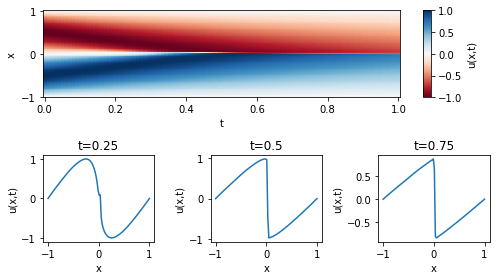

In [9]:
# predict u(t,x) distribution
t_flat = np.linspace(0, 1, n_test)
x_flat = np.linspace(-1, 1, n_test)
x,t = np.meshgrid(x_flat, t_flat)
xt = np.stack([x.flatten(), t.flatten()], axis=-1)
u = dnn.predict(xt, batch_size=n_test)
u = u.reshape(t.shape)

# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap='RdBu')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)

# plot u(t=const, x) cross-sections
t_cross_sections = [0.25, 0.5, 0.75]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    xt = np.stack([x_flat, np.full(t_flat.shape, t_cs)], axis=-1)
    u = dnn.predict(xt, batch_size = n_test)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
plt.show()

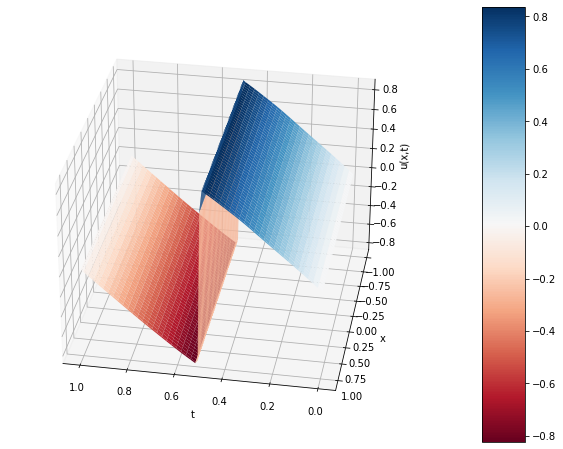

In [10]:
# plot u(t,x) distribution as a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(t, x, u, cmap='RdBu', linewidth=0, antialiased=True)

# Customize the plot
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x,t)')
# Rotate the plot
elevation_angle = ax.elev  # keep the same elevation angle
azimuthal_angle = ax.azim + 160  # change the azimuthal angle by 90 degrees
ax.view_init(elevation_angle, azimuthal_angle)
fig.colorbar(surf, pad=0.1, aspect=10)

plt.show()

## Model Graphs

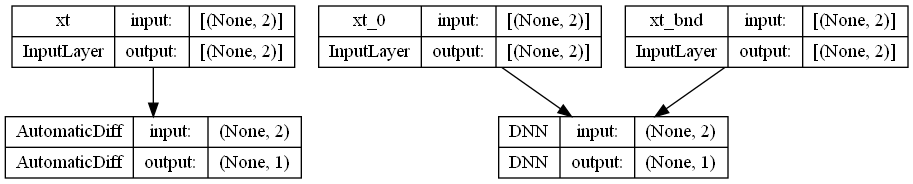

In [11]:
xt = Input(shape = (2,), name = "xt")
xt_0 = Input(shape = (2,), name = "xt_0")
xt_bnd = Input(shape = (2,), name = "xt_bnd")
x_train = (xt, xt_0, xt_bnd)

#dnn = DNN()
#pinn_model = PINN(dnn)

model = Model(inputs = x_train, outputs = pinn.call(x_train))
plot_model(model, show_shapes=True, show_layer_names=True)